In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [143]:
base_path = "/home/jinjinjara1022/"

weather_forecast_data_1 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_1.csv")
weather_forecast_data_2 = pd.read_csv(base_path + "OBIC/data/기상예측데이터_2.csv")  

weather_observed_data_1 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_1.csv")
weather_observed_data_2 = pd.read_csv(base_path + "OBIC/data/기상실측데이터_2.csv")  
  
jeju_power_market_day_ahead = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_하루전가격.csv")
jeju_power_market_real_time = pd.read_csv(base_path + "OBIC/data/제주전력시장_시장전기가격_실시간가격.csv")

jeju_power_market_status = pd.read_csv(base_path + "OBIC/data/제주전력시장_현황데이터.csv")

In [144]:
df = pd.merge(jeju_power_market_day_ahead, jeju_power_market_status, on='ts', how='left')

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ts              5665 non-null   int64  
 1   하루전가격(원/kWh)    5665 non-null   float64
 2   공급능력(kW)        5607 non-null   float64
 3   현재 수요(kW)       5607 non-null   float64
 4   태양광 발전량kW)      5607 non-null   float64
 5   풍력 발전량(kW)      5607 non-null   float64
 6   신재생 발전량 총합(kW)  5607 non-null   float64
 7   공급 예비력(kW)      5607 non-null   float64
 8   운영 예비력(kW)      5607 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 398.4 KB


In [146]:
for column in df.columns:
    if df[column].isnull().any():  # 결측값이 있는 열만 처리
        df[column] = df[column].fillna(df[column].rolling(window=48, min_periods=1, center=True).mean())

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ts              5665 non-null   int64  
 1   하루전가격(원/kWh)    5665 non-null   float64
 2   공급능력(kW)        5665 non-null   float64
 3   현재 수요(kW)       5665 non-null   float64
 4   태양광 발전량kW)      5665 non-null   float64
 5   풍력 발전량(kW)      5665 non-null   float64
 6   신재생 발전량 총합(kW)  5665 non-null   float64
 7   공급 예비력(kW)      5665 non-null   float64
 8   운영 예비력(kW)      5665 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 398.4 KB


In [148]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

features = df.iloc[:, 2:]

scaler = MinMaxScaler()

normalized_features = scaler.fit_transform(features)

normalized_df = pd.DataFrame(normalized_features, columns=features.columns)

final_df = pd.concat([df.iloc[:, :2], normalized_df], axis=1)

final_df['시간'] = pd.to_datetime(final_df['ts'], unit='s').dt.hour

# 시간대에 대한 사인과 코사인 변환
final_df['sin_hour'] = np.sin(2 * np.pi * final_df['시간'] / 24)
final_df['cos_hour'] = np.cos(2 * np.pi * final_df['시간'] / 24)

final_df = final_df.drop(['ts', '시간'], axis=1)
final_df = final_df[[col for col in final_df.columns if col != '하루전가격(원/kWh)'] + ['하루전가격(원/kWh)']]

In [152]:
final_df.columns

Index(['공급능력(kW)', '현재 수요(kW)', '태양광 발전량kW)', '풍력 발전량(kW)', '신재생 발전량 총합(kW)',
       '공급 예비력(kW)', '운영 예비력(kW)', 'sin_hour', 'cos_hour', '하루전가격(원/kWh)'],
      dtype='object')

In [157]:
final_df = final_df[['운영 예비력(kW)', 'sin_hour', 'cos_hour', '하루전가격(원/kWh)']]

In [158]:
train_df = final_df[:5000]
test_df = final_df[5000:]

In [159]:
train_df

,운영 예비력(kW),sin_hour,cos_hour,하루전가격(원/kWh)
0,0.283742,-0.707107,-7.071068e-01,107.39
1,0.300613,-0.866025,-5.000000e-01,107.39
2,0.400307,-0.965926,-2.588190e-01,95.30
3,0.371166,-1.000000,-1.836970e-16,87.89
4,0.331288,-0.965926,2.588190e-01,0.00
...,...,...,...,...
4995,0.369632,-1.000000,-1.836970e-16,106.43
4996,0.349693,-0.965926,2.588190e-01,106.20
4997,0.349693,-0.866025,5.000000e-01,106.17
4998,0.320552,-0.707107,7.071068e-01,106.40


In [162]:
input_size = 4  # feature의 개수
hidden_size = 32
num_layers = 3
output_size = 1
num_epochs = 100
window_size = 48  # 예측에 사용될 시간 윈도우 크기
batch_size = 32
learning_rate = 0.001

In [163]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   운영 예비력(kW)    5000 non-null   float64
 1   sin_hour      5000 non-null   float64
 2   cos_hour      5000 non-null   float64
 3   하루전가격(원/kWh)  5000 non-null   float64
dtypes: float64(4)
memory usage: 156.4 KB


In [164]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class TimeSeriesDataset(Dataset):
    def __init__(self, df, window_size):
        self.df = df.values
        self.window_size = window_size

    def __len__(self):
        return len(self.df) - self.window_size

    def __getitem__(self, idx):
        x = torch.tensor(self.df[idx:idx+self.window_size, :], dtype=torch.float)
        y = torch.tensor(self.df[idx+self.window_size, -1], dtype=torch.float)
        return x, y


def create_data_loader(df, window_size, batch_size):
    dataset = TimeSeriesDataset(df, window_size)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return data_loader

train_loader = create_data_loader(train_df, window_size, batch_size)

In [165]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

In [166]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"current device: {device}")

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

current device: cuda


In [167]:
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        
        inputs = inputs.to(device)
        labels = labels.unsqueeze(1).to(device)

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/100], Step [155/155], Loss: 24108.6406
Epoch [2/100], Step [155/155], Loss: 22538.1719
Epoch [3/100], Step [155/155], Loss: 21119.7266
Epoch [4/100], Step [155/155], Loss: 19801.3750
Epoch [5/100], Step [155/155], Loss: 18566.1211
Epoch [6/100], Step [155/155], Loss: 17405.0078
Epoch [7/100], Step [155/155], Loss: 16312.1045
Epoch [8/100], Step [155/155], Loss: 15282.9170
Epoch [9/100], Step [155/155], Loss: 14313.7764
Epoch [10/100], Step [155/155], Loss: 13401.5342
Epoch [11/100], Step [155/155], Loss: 12543.4043
Epoch [12/100], Step [155/155], Loss: 11736.8770
Epoch [13/100], Step [155/155], Loss: 10979.6357
Epoch [14/100], Step [155/155], Loss: 10269.5459
Epoch [15/100], Step [155/155], Loss: 9604.5986
Epoch [16/100], Step [155/155], Loss: 8982.8984
Epoch [17/100], Step [155/155], Loss: 8402.6426
Epoch [18/100], Step [155/155], Loss: 7862.1016
Epoch [19/100], Step [155/155], Loss: 7359.6094
Epoch [20/100], Step [155/155], Loss: 6893.5459
Epoch [21/100], Step [155/155], Los

In [168]:
test_loader = create_data_loader(test_df, window_size, 1)

In [169]:
real = []
preds = []
pred = None

for idx, (X, y) in enumerate(test_loader):
    if idx < 180: continue
    if pred:
        inputs = X.to(device)
        inputs[0][-1][-1] = pred
        outputs = model(inputs)
    else:
        inputs = X.to(device)
        outputs = model(inputs)
    
    pred = float(outputs)
    y = float(y)

    real.append(y)
    preds.append(pred)
    
    if idx == 226:
        break

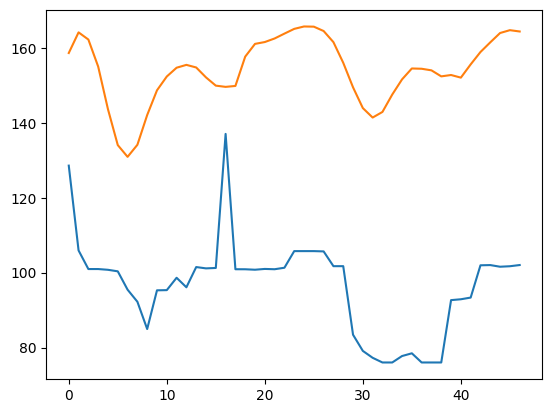

In [170]:
plt.plot(real)
plt.plot(preds)

In [171]:
real = []
preds = []

for idx, (X, y) in enumerate(test_loader):
    if idx < 180: continue    
    inputs = X.to(device)
    
    outputs = model(inputs)
    
    pred = float(outputs)
    y = float(y)

    real.append(y)
    preds.append(pred)
    
    if idx == 226:
        break

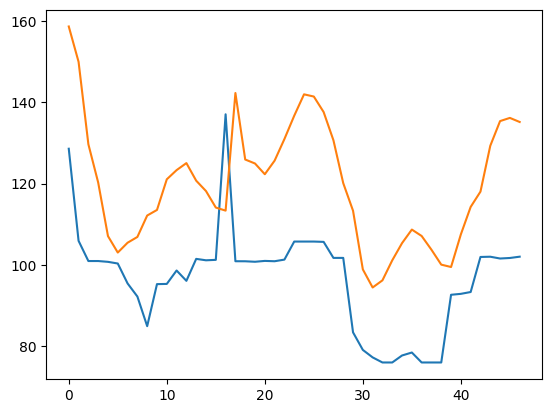

In [172]:
plt.plot(real)
plt.plot(preds)